<a href="https://colab.research.google.com/github/TN108/Air-Quality-Forecasting-with-Deep-Learning-A-Hands-on-Journey/blob/main/PA4_LSTM_TimeSeriesForecasting_11_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌫️ PM2.5 Time Series Forecasting with LSTM & GRU (From Scratch + Library)

## 📘 Assignment Overview

In this assignment, you will work with the **Beijing PM2.5 time series dataset**, which contains hourly pollution measurements recorded over multiple years. Your task is to **forecast PM2.5 concentration** using **Recurrent Neural Networks (RNNs)** — specifically **LSTM** and **GRU** architectures.

The key challenge here is to implement these models **from scratch using PyTorch**, and also compare them against the **official LSTM implementation from PyTorch’s `nn.LSTM` module**. You will preprocess the data, build forecasting models, evaluate performance, and compare all approaches.

---

## 🎯 Objectives

By the end of this assignment, you will be able to:

- Understand and apply time series forecasting techniques using LSTM and GRU models.
- Implement LSTM and GRU architectures **from scratch** in PyTorch.
- Use `nn.LSTM` from PyTorch as a reference baseline.
- Train and evaluate deep learning models on real-world environmental data.
- Compare model performance using metrics like **MSE**, **MAE**, and visual plots.

---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 📊 Task 1: Data Loading and Preprocessing

In this task, you will load and preprocess the **Beijing PM2.5 time series dataset**, which contains air quality and meteorological data collected from the US Embassy in Beijing between 2010 and 2014.

### 📝 Dataset Description:

The dataset includes the following key features:

- **pm2.5**: PM2.5 concentration (in µg/m³) — this is the **target** variable
- **DEWP**: Dew Point
- **TEMP**: Temperature (°C)
- **PRES**: Pressure (hPa)
- **cbwd**: Combined wind direction (categorical)
- **Iws**: Cumulated wind speed (m/s)
- **Is**: Cumulated hours of snow
- **Ir**: Cumulated hours of rain

It also includes separate columns for year, month, day, and hour which you will use to construct the **datetime index** for your time series.

### 📥 Download the Dataset

Please download the dataset from the UCI Machine Learning Repository:

🔗 [Beijing PM2.5 Dataset](https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data)

🧹 Your Tasks in This Section

Load the dataset.

Drop missing values (this dataset contains some missing PM2.5 values).

Construct a datetime column using the year, month, day, and hour columns, and set it as the index.

Select relevant features, including the target variable pm2.5.

One-hot encode the categorical columns.

Normalize the dataset.

Create sequences of length seq_length = 30 to use for time series modeling.

Split the dataset into training (80%) and testing (20%) sets.

Convert the NumPy arrays into PyTorch tensors for model input.

After completing this task, you should have:

X_train_tensor, y_train_tensor: for training

X_test_tensor, y_test_tensor: for evaluation

input_size: number of features per timestep (needed for model initialization)

---

In [ ]:
# Load dataset
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

In [ ]:
# Drop rows with missing PM2.5 values
df = df.dropna(subset=["pm2.5"])

In [ ]:
# Construct datetime index
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
df.set_index("datetime", inplace=True)


In [ ]:
# Select relevant features
features = ["pm2.5", "DEWP", "TEMP", "PRES", "cbwd", "Iws", "Is", "Ir"]
df = df[features]

In [ ]:
# One-hot encode categorical column (cbwd)
df = pd.get_dummies(df, columns=["cbwd"])

In [ ]:
# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [ ]:
# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

In [ ]:

# Create sequences of length 30 (sliding window)
def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # target: pm2.5
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Get input size
input_size = X_train_tensor.shape[2]

print("Data preprocessed.")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")
print(f"Input size: {input_size}")

Data preprocessed.
X_train_tensor shape: torch.Size([33381, 30, 11])
y_train_tensor shape: torch.Size([33381, 1])
X_test_tensor shape: torch.Size([8346, 30, 11])
y_test_tensor shape: torch.Size([8346, 1])
Input size: 11


## 🔧 Task 2: Implementing LSTM From Scratch (No `nn.LSTM`!)

In this section, you will implement the **core logic of the LSTM cell manually**, without using PyTorch’s built-in `nn.LSTM`. This will help you understand the internal gates and computations that make LSTMs work for time series data.

---

### 🔍 What is an LSTM?

An **LSTM (Long Short-Term Memory)** network is a special kind of RNN capable of learning long-term dependencies. It uses **three gates** and a **cell state** to control the flow of information:

- **Forget Gate (`f`)**: What part of the previous cell state to forget
- **Input Gate (`i`)**: What new information to write to the cell
- **Cell State Update (`c̃`)**: Candidate values to add to the cell state
- **Output Gate (`o`)**: What part of the cell state to output

Each gate uses the current input and the previous hidden state to make its decision.

---

### 🛠️ Your Task

Implement an LSTM network from scratch by following these steps:

1. **Create a custom `LSTMCellScratch` class** with:
    - Learnable parameters for each gate using `nn.Linear`
    - Forward pass that applies sigmoid and tanh activations
2. **Create a wrapper `LSTMScratch` class** that:
    - Iterates through each timestep of the input sequence
    - Updates hidden and cell states manually
    - Passes the final hidden state through a fully connected layer

3. **Train your LSTM model** using the provided PM2.5 training data.

4. **Report training loss per epoch**

---

In [ ]:
class LSTMCellScratch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, h, c):
        gates = self.i2h(x) + self.h2h(h)
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i, f, o, g = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o), torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class LSTMScratch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = LSTMCellScratch(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.zeros(x.size(0), self.hidden_size)
        c = torch.zeros(x.size(0), self.hidden_size)
        for t in range(x.size(1)):
            h, c = self.cell(x[:, t, :], h, c)
        return self.fc(h)


## 🔁 Task 3: Implementing GRU From Scratch

In this task, you'll build and train a **GRU (Gated Recurrent Unit)** network manually — again, **without using `nn.GRU`**. This simplified RNN variant is computationally efficient and often performs competitively with LSTMs on time series data.

---

### 🔍 How is GRU Different from LSTM?

GRU simplifies the gating mechanism used in LSTMs. Instead of maintaining separate cell and hidden states, GRUs combine them into a **single hidden state** and use only **two gates**:

- **Update Gate (`z`)**: Determines how much of the past hidden state to keep
- **Reset Gate (`r`)**: Decides how much of the past information to forget
- **Candidate Hidden State (`h̃`)**: New content to potentially update the hidden state

The result is a more lightweight and efficient architecture.

---

### 🛠️ Your Task

1. **Implement `GRUCellScratch`**:
    - Define linear layers for update, reset, and candidate gates.
    - Apply appropriate activation functions (sigmoid for gates, tanh for candidate).

2. **Build the `GRUScratch` wrapper class**:
    - Iterate through the input sequence.
    - Pass each timestep through the GRU cell.
    - Pass the final hidden state through a fully connected output layer.

3. **Train the GRU model** on the PM2.5 dataset.

4. **Track training loss** over multiple epochs.


In [ ]:
class GRUCellScratch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.x2z = nn.Linear(input_size, hidden_size)
        self.h2z = nn.Linear(hidden_size, hidden_size)
        self.x2r = nn.Linear(input_size, hidden_size)
        self.h2r = nn.Linear(hidden_size, hidden_size)
        self.x2n = nn.Linear(input_size, hidden_size)
        self.h2n = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h_prev):
        z = torch.sigmoid(self.x2z(x) + self.h2z(h_prev))
        r = torch.sigmoid(self.x2r(x) + self.h2r(h_prev))
        n = torch.tanh(self.x2n(x) + r * self.h2n(h_prev))
        h = (1 - z) * n + z * h_prev
        return h

class GRUScratch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = GRUCellScratch(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.zeros(x.size(0), self.cell.x2z.out_features)
        for t in range(x.size(1)):
            h = self.cell(x[:, t, :], h)
        return self.fc(h)


## 🧠 Task 4: Using PyTorch’s Built-in `nn.LSTM` and `nn.GRU`

Now that you've implemented LSTM and GRU **from scratch**, it's time to compare them with **PyTorch's built-in implementation**. This will serve as your baseline reference for performance, ease of implementation, and training stability.

---

### 🛠️ Your Task

1. Create a model using `nn.LSTM` followed by a `nn.Linear` layer to map the final hidden state to the output.
2. Create another model use `nn.GRU` followed by a `nn.Linear` layer to map the final hidden state to the output.
2. Train both models using the same preprocessed PM2.5 dataset.
3. Record training loss for each epoch and compare with earlier models.

> ✅ **Reminder**: PyTorch's `nn.LSTM` and `nn.GRU` returns all hidden states for the full sequence. To predict PM2.5, we use only the **last hidden state** (i.e., the output at the final timestep).

---

In [ ]:
class LSTM_PyTorch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

class GRU_PyTorch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n[-1])


## 📊 Task 5: Evaluating and Comparing Models

Now that you've successfully trained:

- ✅ **LSTM from scratch**
- ✅ **GRU from scratch**
- ✅ **Built-in PyTorch LSTM**
- ✅ **Built-in PyTorch GRU**

…it’s time to evaluate their performance on the **test set**.

---

### 🧪 Evaluation Metrics

We will evaluate each model using the following metrics:

- **RMSE (Root Mean Squared Error):** Penalizes larger errors more heavily.
- **MAE (Mean Absolute Error):** Measures average magnitude of errors.
- **Pseudo-Accuracy:** Measures how often the prediction is within ±20% of the actual value — a tolerance-based “accuracy”.
- **Prediction Plot:** A side-by-side comparison of predicted vs actual PM2.5 concentrations over time.

---

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, lr=1e-3, epochs=20):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    model.eval()
    preds = model(X_test).detach().numpy()
    true = y_test.numpy()
    return preds, true

# Run all models
hidden_size = 64
models = {
    "LSTM (Scratch)": LSTMScratch(input_size, hidden_size),
    "GRU (Scratch)": GRUScratch(input_size, hidden_size),
    "LSTM (nn.LSTM)": LSTM_PyTorch(input_size, hidden_size),
    "GRU (nn.GRU)": GRU_PyTorch(input_size, hidden_size)
}

results = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    preds, true = train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
    results[name] = (preds, true)



=== Training LSTM (Scratch) ===
Epoch 1, Loss: 0.0679
Epoch 2, Loss: 0.0525
Epoch 3, Loss: 0.0393
Epoch 4, Loss: 0.0284
Epoch 5, Loss: 0.0197
Epoch 6, Loss: 0.0135
Epoch 7, Loss: 0.0098
Epoch 8, Loss: 0.0086
Epoch 9, Loss: 0.0095
Epoch 10, Loss: 0.0117
Epoch 11, Loss: 0.0138
Epoch 12, Loss: 0.0149
Epoch 13, Loss: 0.0148
Epoch 14, Loss: 0.0138
Epoch 15, Loss: 0.0123
Epoch 16, Loss: 0.0108
Epoch 17, Loss: 0.0094
Epoch 18, Loss: 0.0083
Epoch 19, Loss: 0.0077
Epoch 20, Loss: 0.0073

=== Training GRU (Scratch) ===
Epoch 1, Loss: 0.0230
Epoch 2, Loss: 0.0195
Epoch 3, Loss: 0.0171
Epoch 4, Loss: 0.0145
Epoch 5, Loss: 0.0126
Epoch 6, Loss: 0.0113
Epoch 7, Loss: 0.0103
Epoch 8, Loss: 0.0094
Epoch 9, Loss: 0.0088
Epoch 10, Loss: 0.0085
Epoch 11, Loss: 0.0083
Epoch 12, Loss: 0.0080
Epoch 13, Loss: 0.0077
Epoch 14, Loss: 0.0075
Epoch 15, Loss: 0.0073
Epoch 16, Loss: 0.0071
Epoch 17, Loss: 0.0069
Epoch 18, Loss: 0.0066
Epoch 19, Loss: 0.0065
Epoch 20, Loss: 0.0063

=== Training LSTM (nn.LSTM) ===


In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, lr=1e-3, epochs=20):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    model.eval()
    preds = model(X_test).detach().numpy()
    true = y_test.numpy()
    return preds, true

# Run all models
hidden_size = 128
models = {
    "LSTM (Scratch)": LSTMScratch(input_size, hidden_size),
    "GRU (Scratch)": GRUScratch(input_size, hidden_size),
    "LSTM (nn.LSTM)": LSTM_PyTorch(input_size, hidden_size),
    "GRU (nn.GRU)": GRU_PyTorch(input_size, hidden_size)
}

results = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    preds, true = train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
    results[name] = (preds, true)



=== Training LSTM (Scratch) ===
Epoch 1, Loss: 0.0174
Epoch 2, Loss: 0.0084
Epoch 3, Loss: 0.0090
Epoch 4, Loss: 0.0109
Epoch 5, Loss: 0.0101
Epoch 6, Loss: 0.0081
Epoch 7, Loss: 0.0067
Epoch 8, Loss: 0.0064
Epoch 9, Loss: 0.0070
Epoch 10, Loss: 0.0074
Epoch 11, Loss: 0.0074
Epoch 12, Loss: 0.0068
Epoch 13, Loss: 0.0061
Epoch 14, Loss: 0.0056
Epoch 15, Loss: 0.0055
Epoch 16, Loss: 0.0056
Epoch 17, Loss: 0.0058
Epoch 18, Loss: 0.0057
Epoch 19, Loss: 0.0054
Epoch 20, Loss: 0.0051

=== Training GRU (Scratch) ===
Epoch 1, Loss: 0.0430
Epoch 2, Loss: 0.0199
Epoch 3, Loss: 0.0222
Epoch 4, Loss: 0.0228
Epoch 5, Loss: 0.0168
Epoch 6, Loss: 0.0108
Epoch 7, Loss: 0.0088
Epoch 8, Loss: 0.0103
Epoch 9, Loss: 0.0120
Epoch 10, Loss: 0.0117
Epoch 11, Loss: 0.0098
Epoch 12, Loss: 0.0080
Epoch 13, Loss: 0.0074
Epoch 14, Loss: 0.0080
Epoch 15, Loss: 0.0086
Epoch 16, Loss: 0.0084
Epoch 17, Loss: 0.0074
Epoch 18, Loss: 0.0063
Epoch 19, Loss: 0.0057
Epoch 20, Loss: 0.0058

=== Training LSTM (nn.LSTM) ===



LSTM (Scratch):
  RMSE: 0.0726, MAE: 0.0547, Pseudo-Accuracy: 0.1937


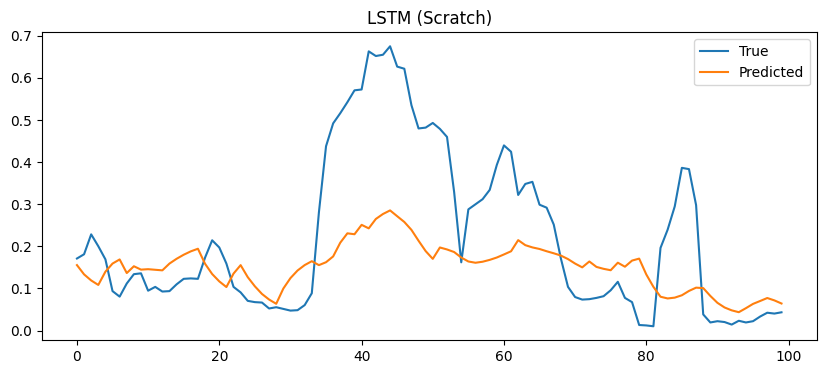


GRU (Scratch):
  RMSE: 0.0806, MAE: 0.0541, Pseudo-Accuracy: 0.1902


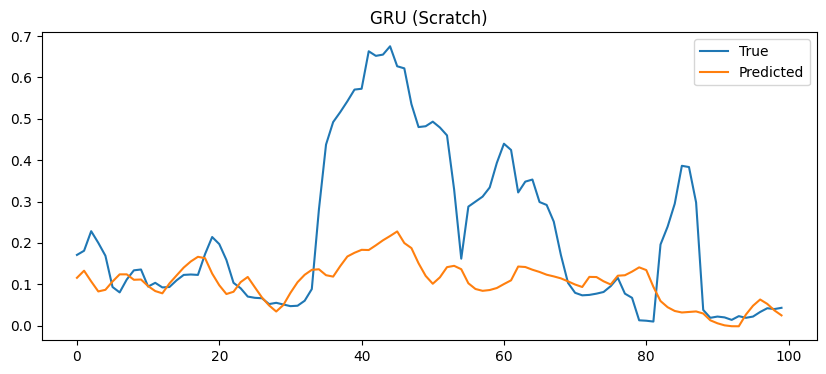


LSTM (nn.LSTM):
  RMSE: 0.0719, MAE: 0.0499, Pseudo-Accuracy: 0.2067


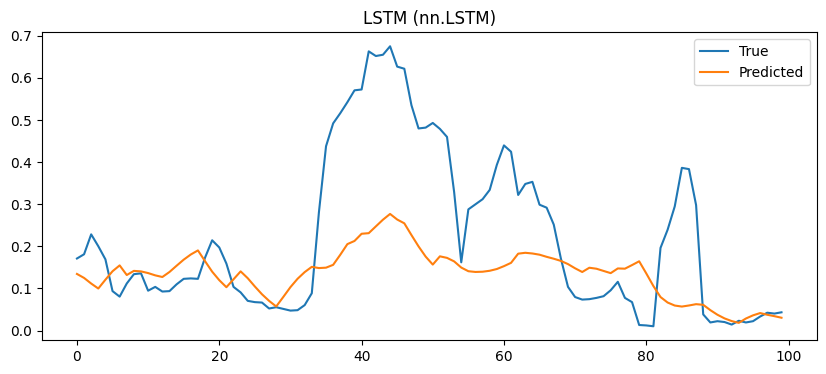


GRU (nn.GRU):
  RMSE: 0.0810, MAE: 0.0582, Pseudo-Accuracy: 0.1813


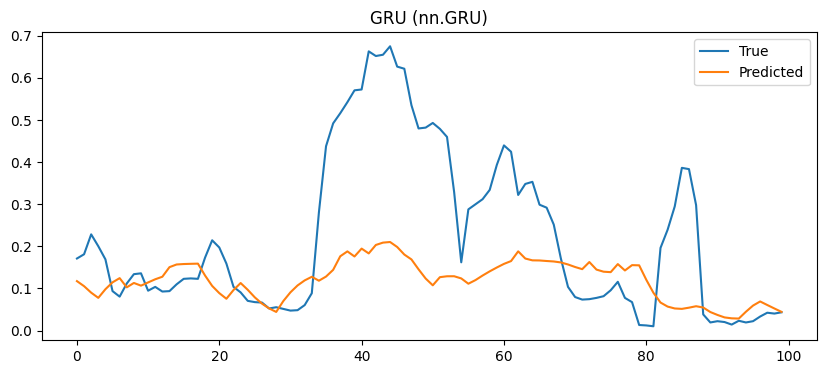

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(preds, true):
    rmse = np.sqrt(mean_squared_error(true, preds))
    mae = mean_absolute_error(true, preds)
    pseudo_acc = np.mean(np.abs(preds - true) <= 0.2 * np.abs(true))
    return rmse, mae, pseudo_acc

for name, (preds, true) in results.items():
    rmse, mae, acc = evaluate(preds, true)
    print(f"\n{name}:\n  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Pseudo-Accuracy: {acc:.4f}")
    plt.figure(figsize=(10,4))
    plt.plot(true[:100], label='True')
    plt.plot(preds[:100], label='Predicted')
    plt.title(name)
    plt.legend()
    plt.show()


## Task 6: Analytical Questions

Q1: Does the simpler GRU model perform comparably to the LSTM on this dataset? If it does, what factors might explain this performance parity? If it does not, under what conditions might their results converge or become more similar?

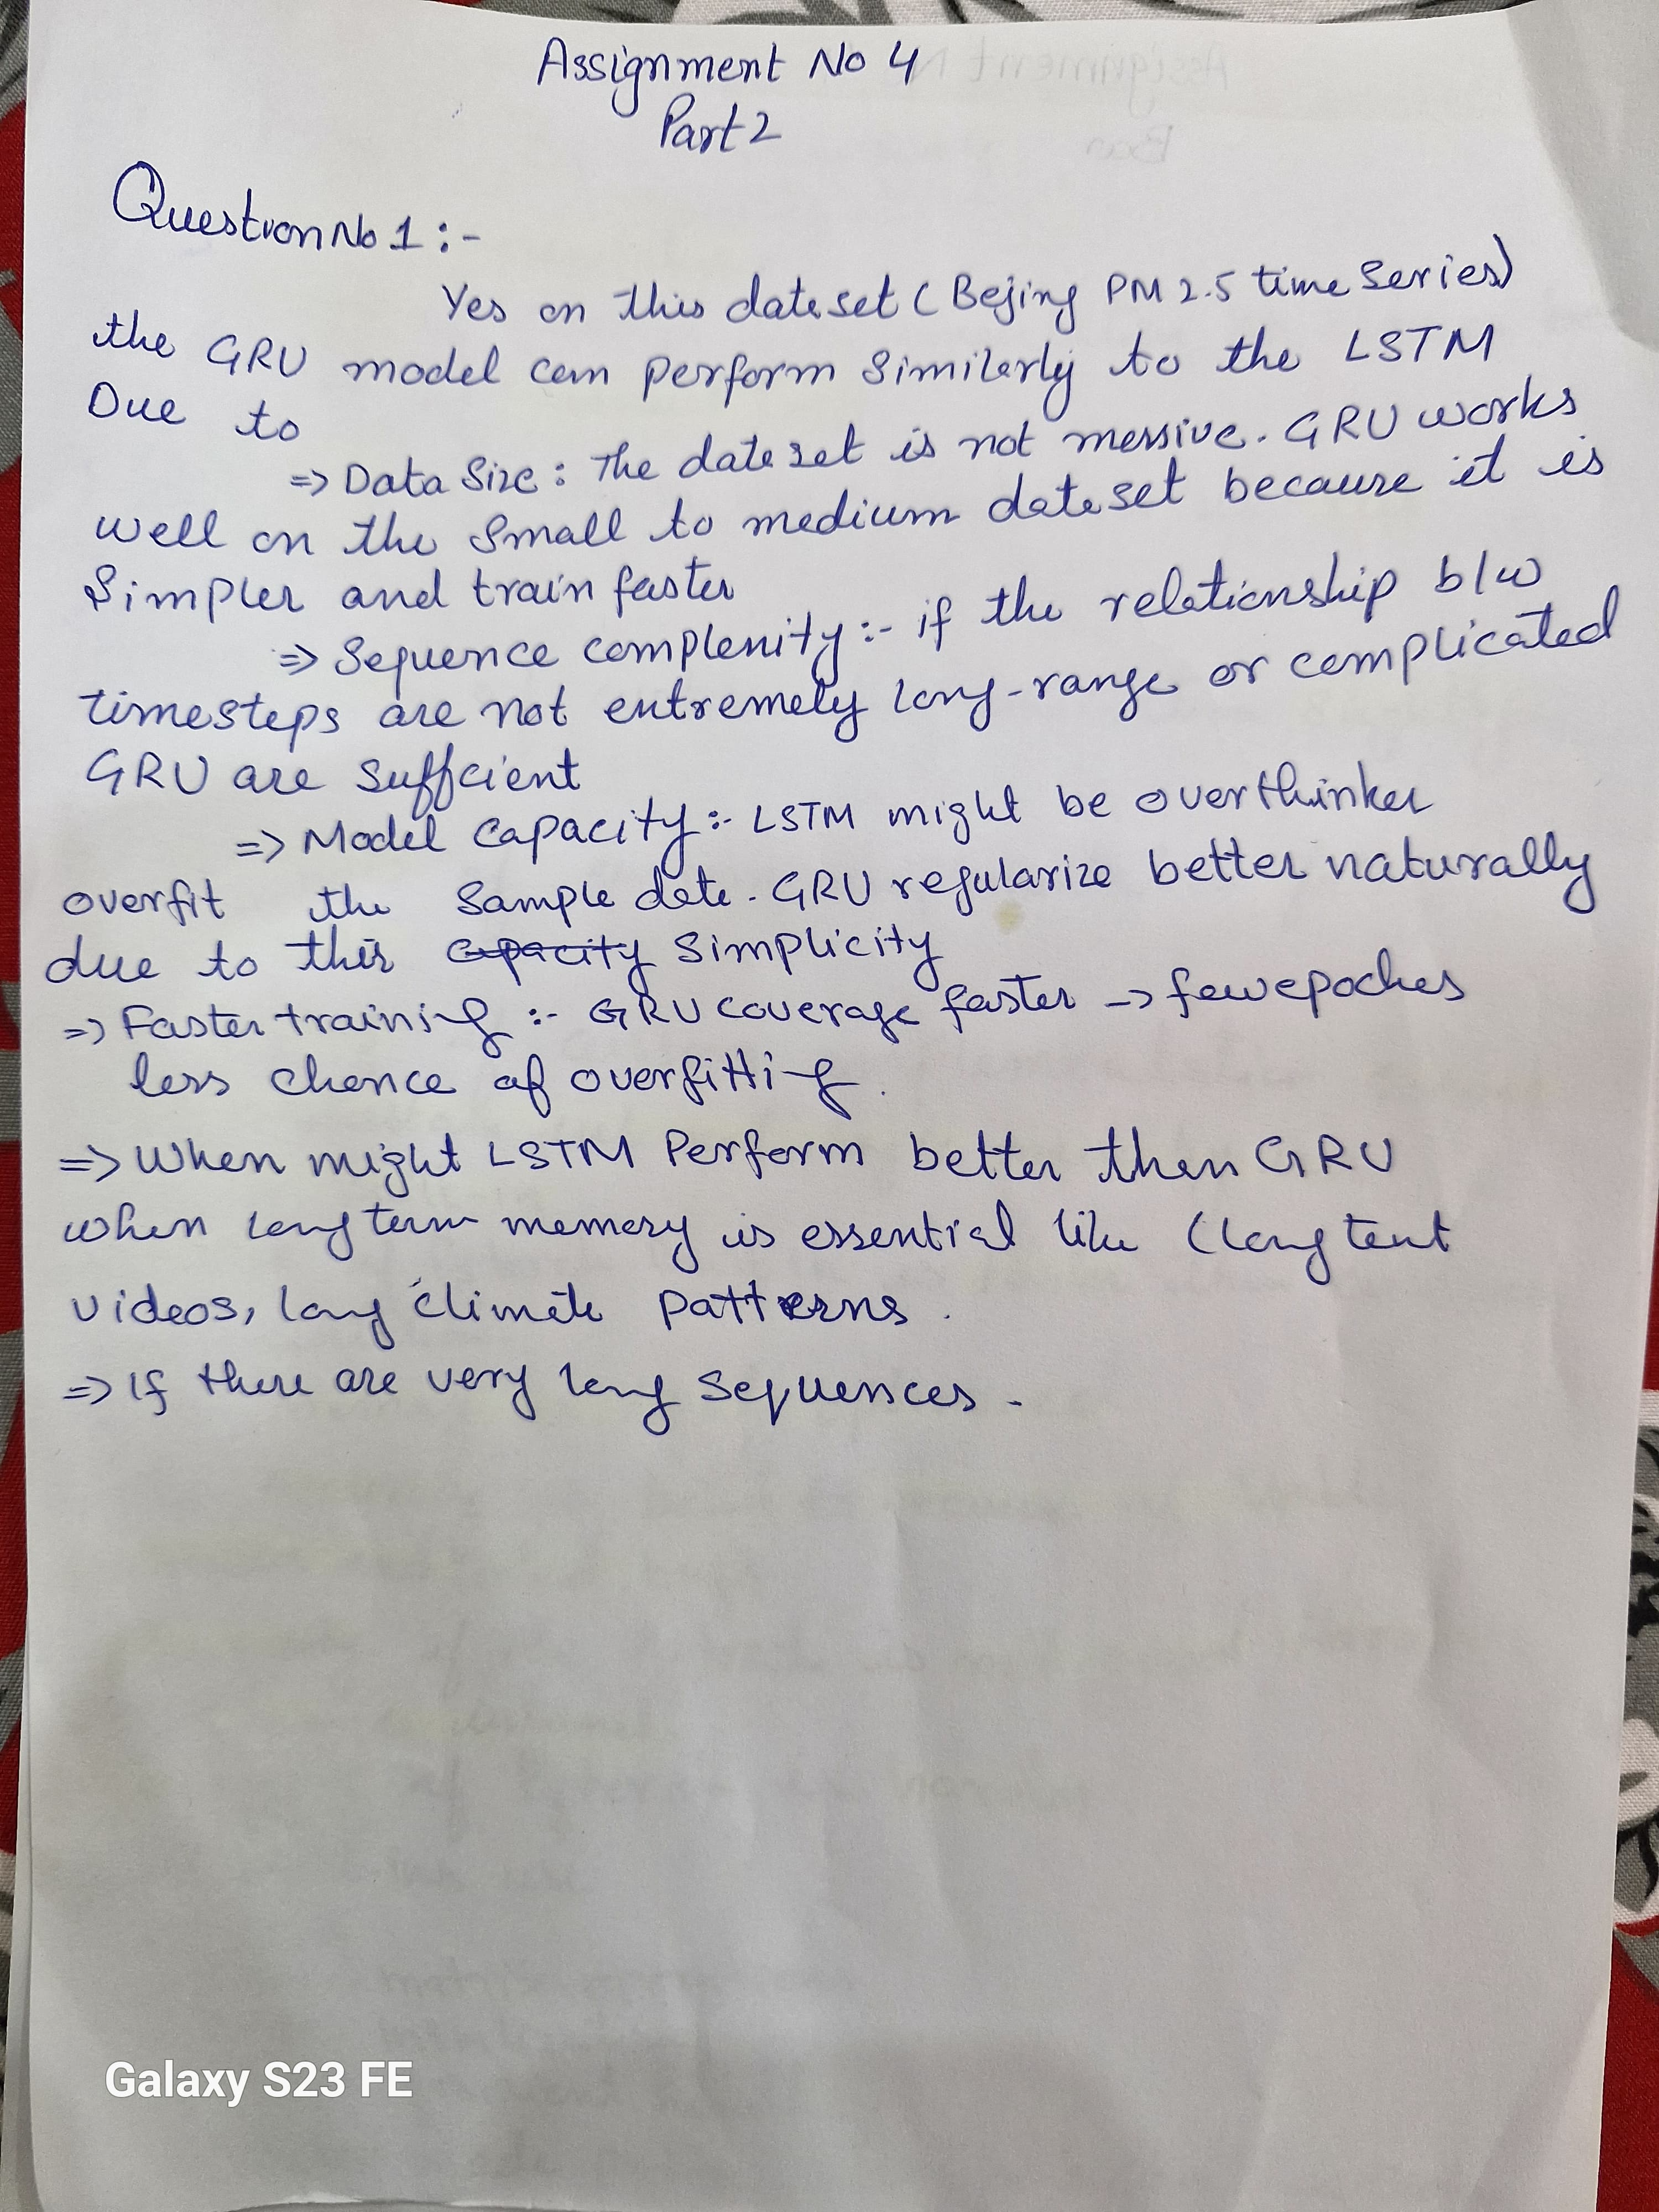**Answer here**

Q2: In what ways does the architecture of an LSTM help mitigate the vanishing and exploding gradient problems commonly encountered in training recurrent neural networks?

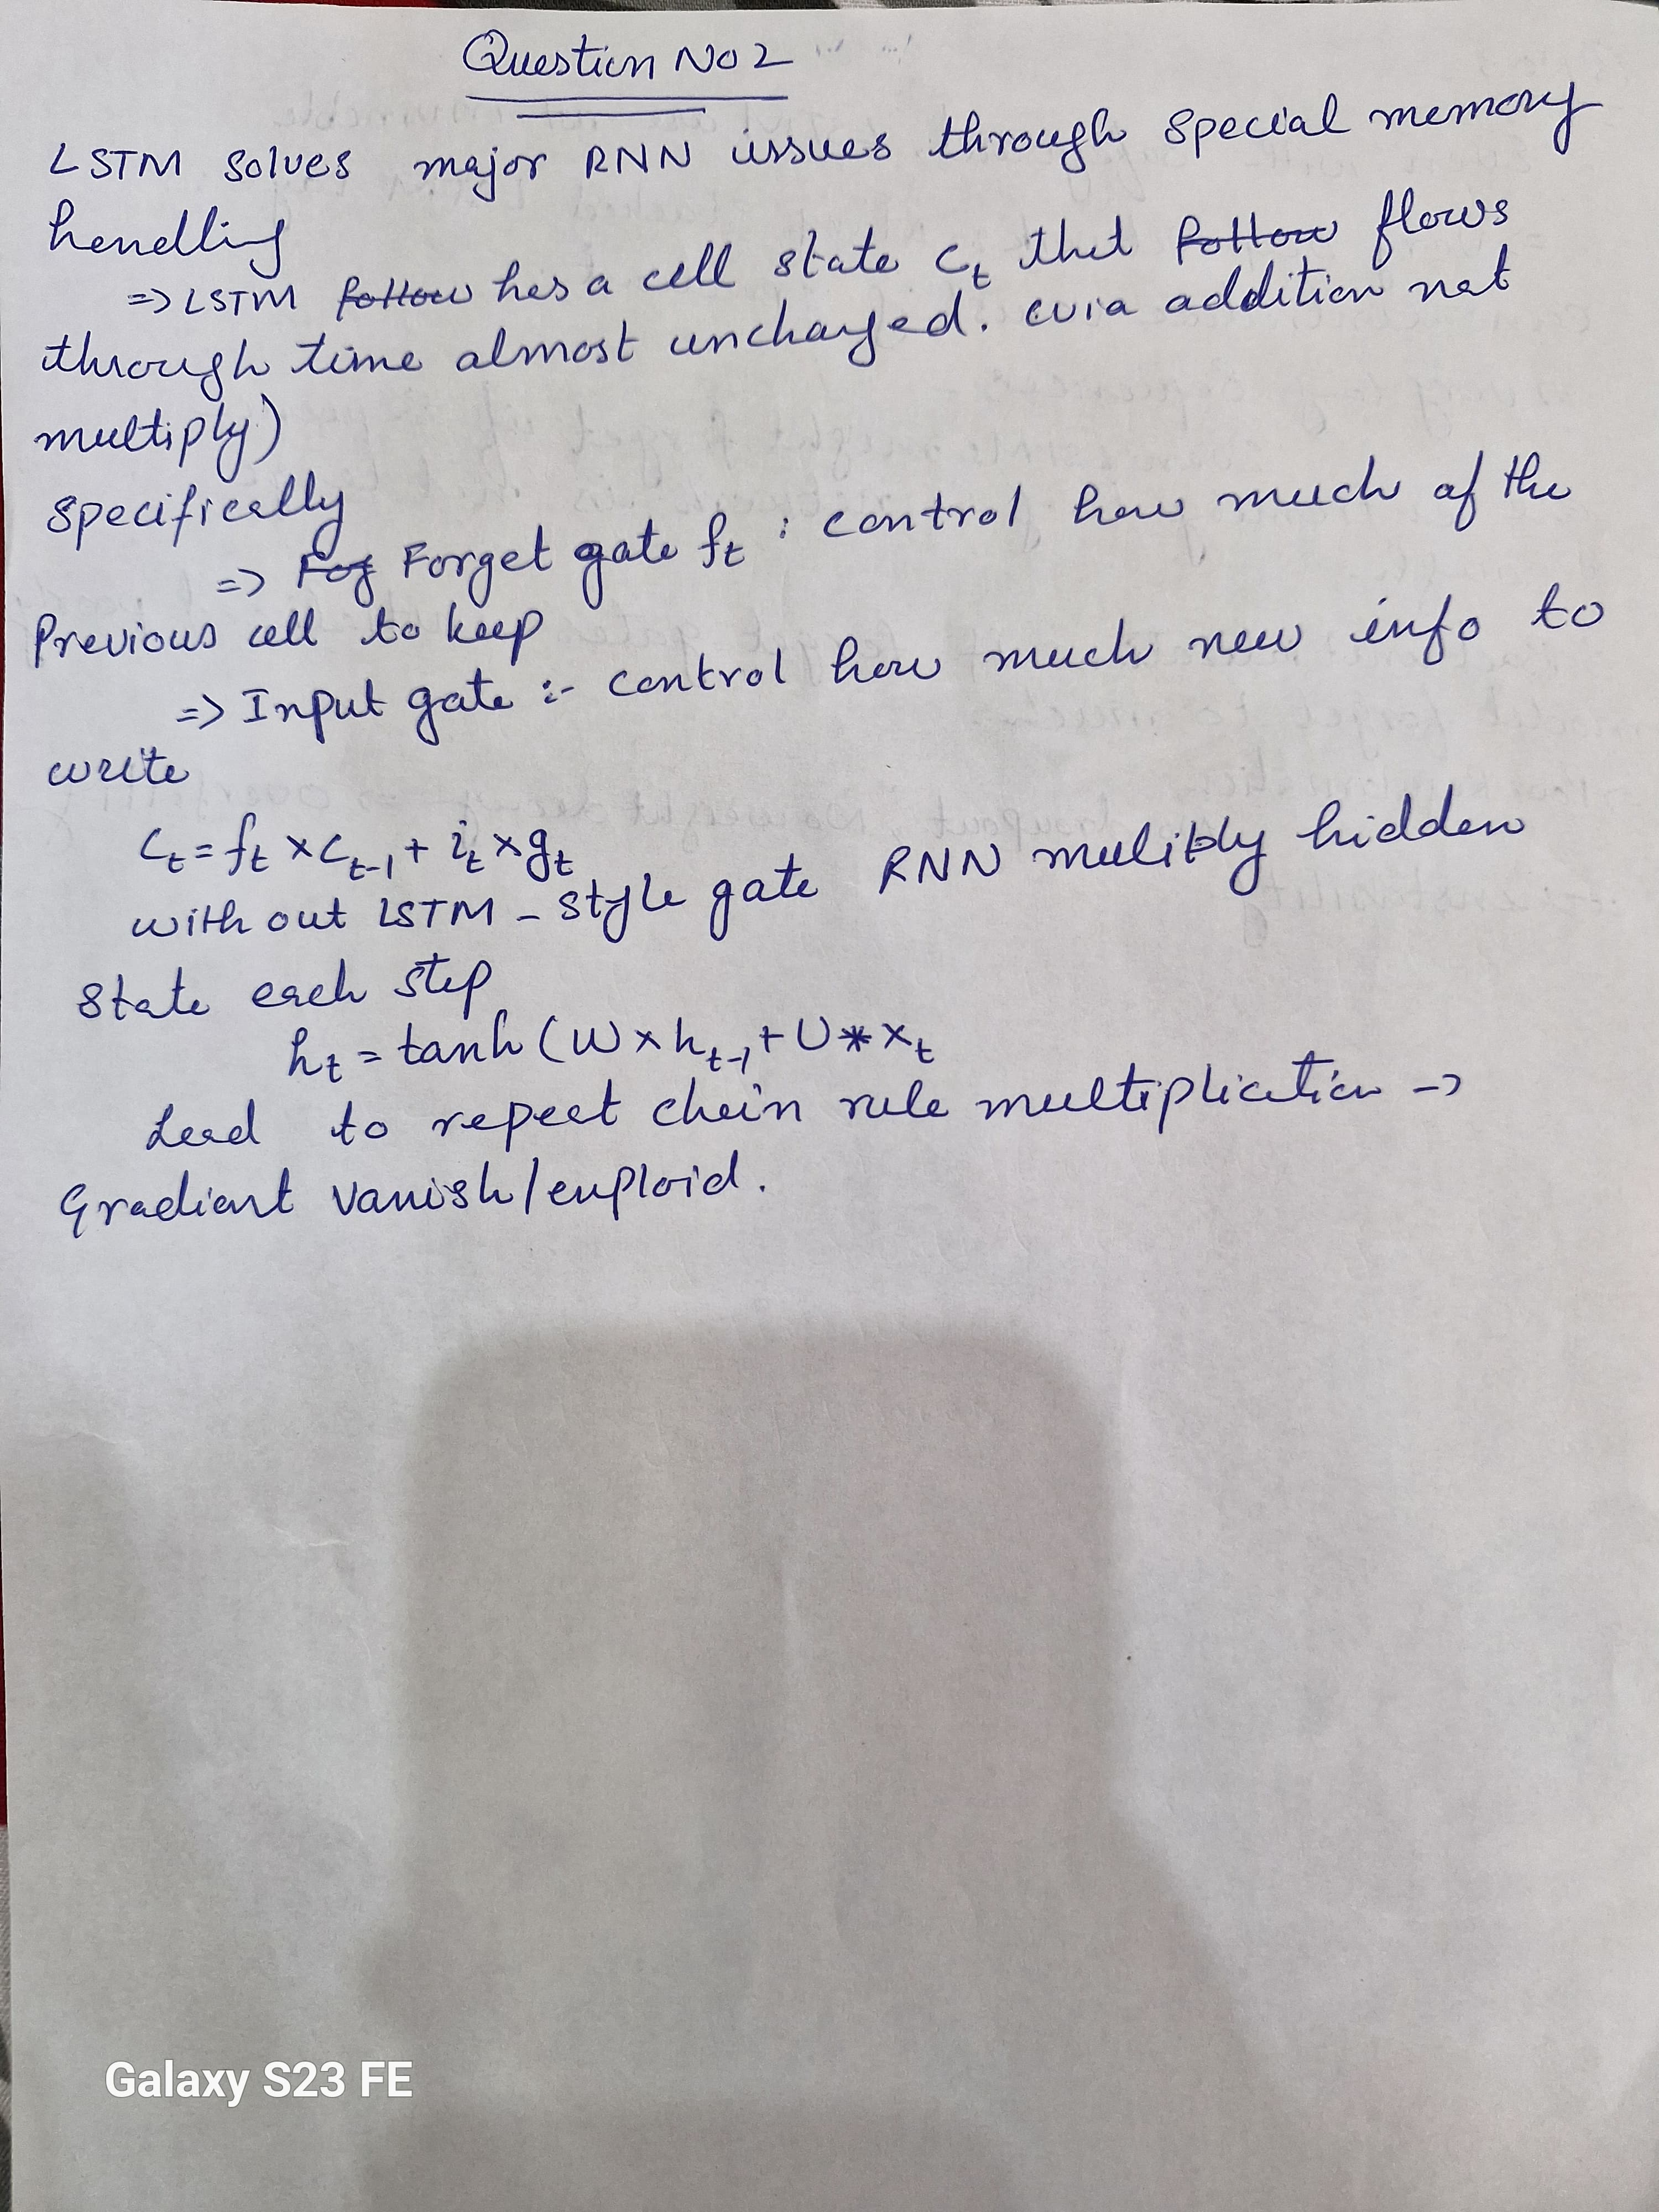**Answer here**

Q3: Are there scenarios where an LSTM may still suffer from vanishing or exploding gradients despite its architectural safeguards? If so, what might those scenarios be?

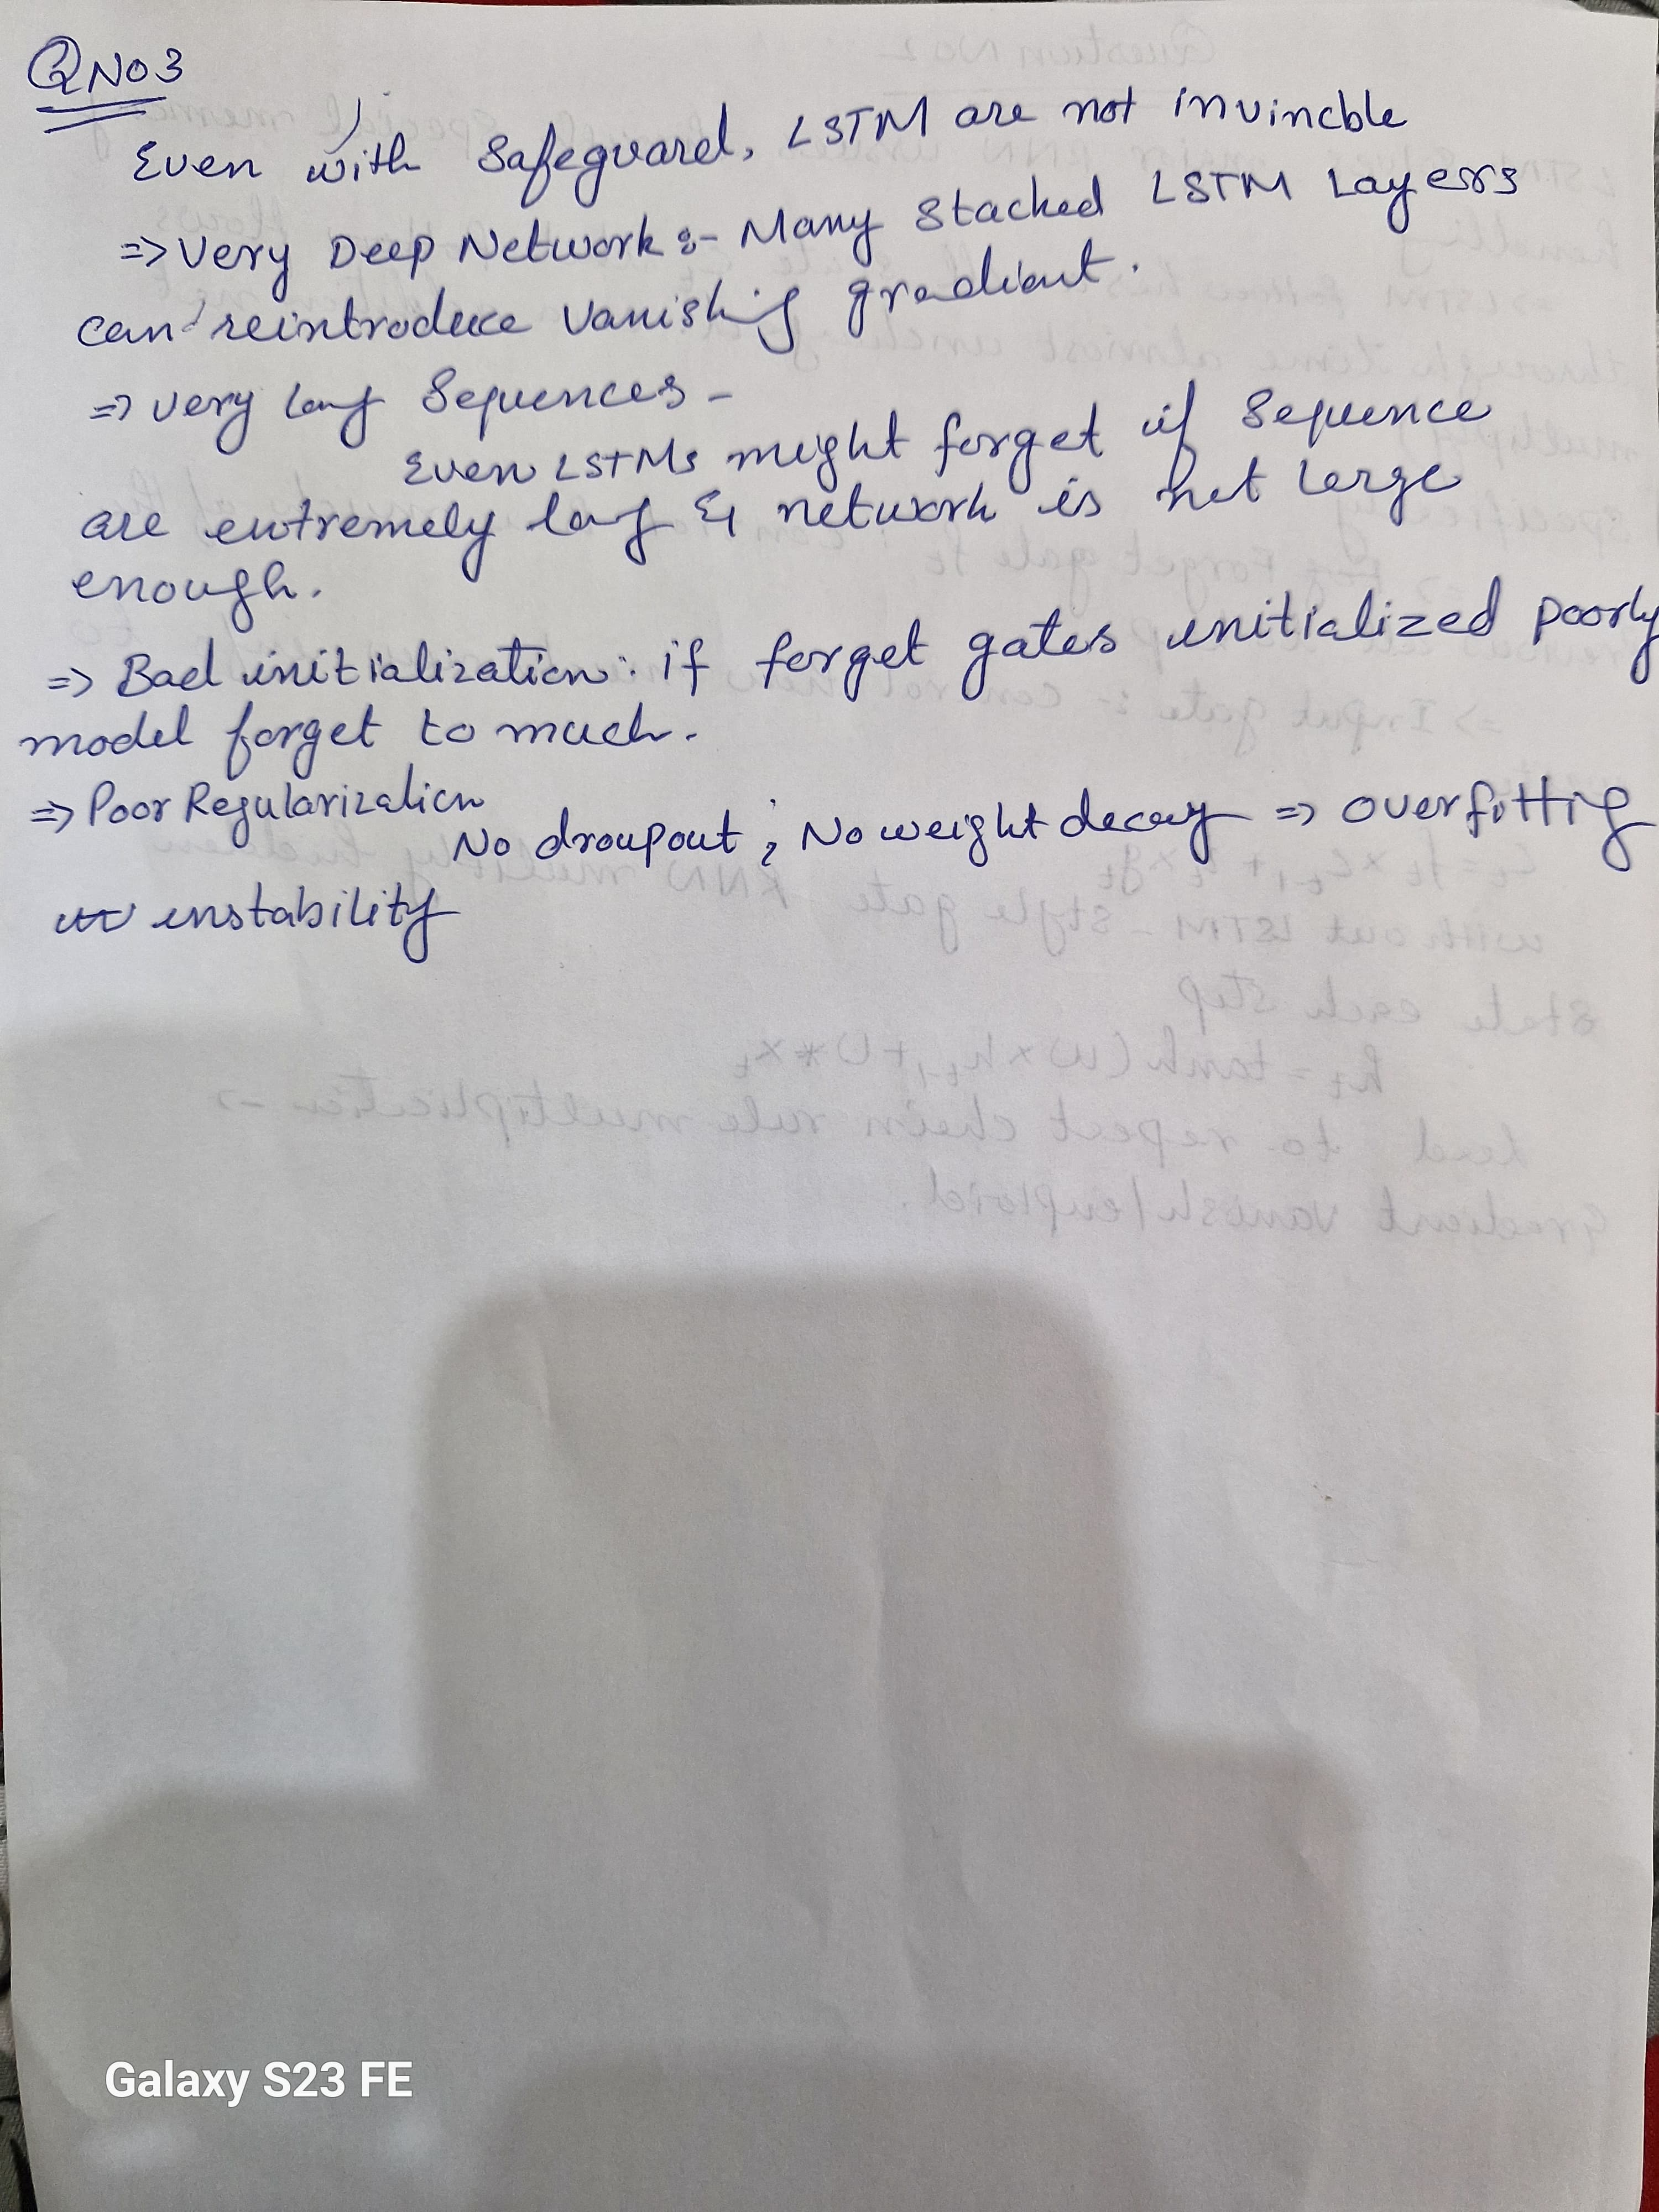**Answer here**

Q4: How do your custom implementations compare to PyTorch’s built-in modules? Which one performs better, and what factors might explain the difference in performance?


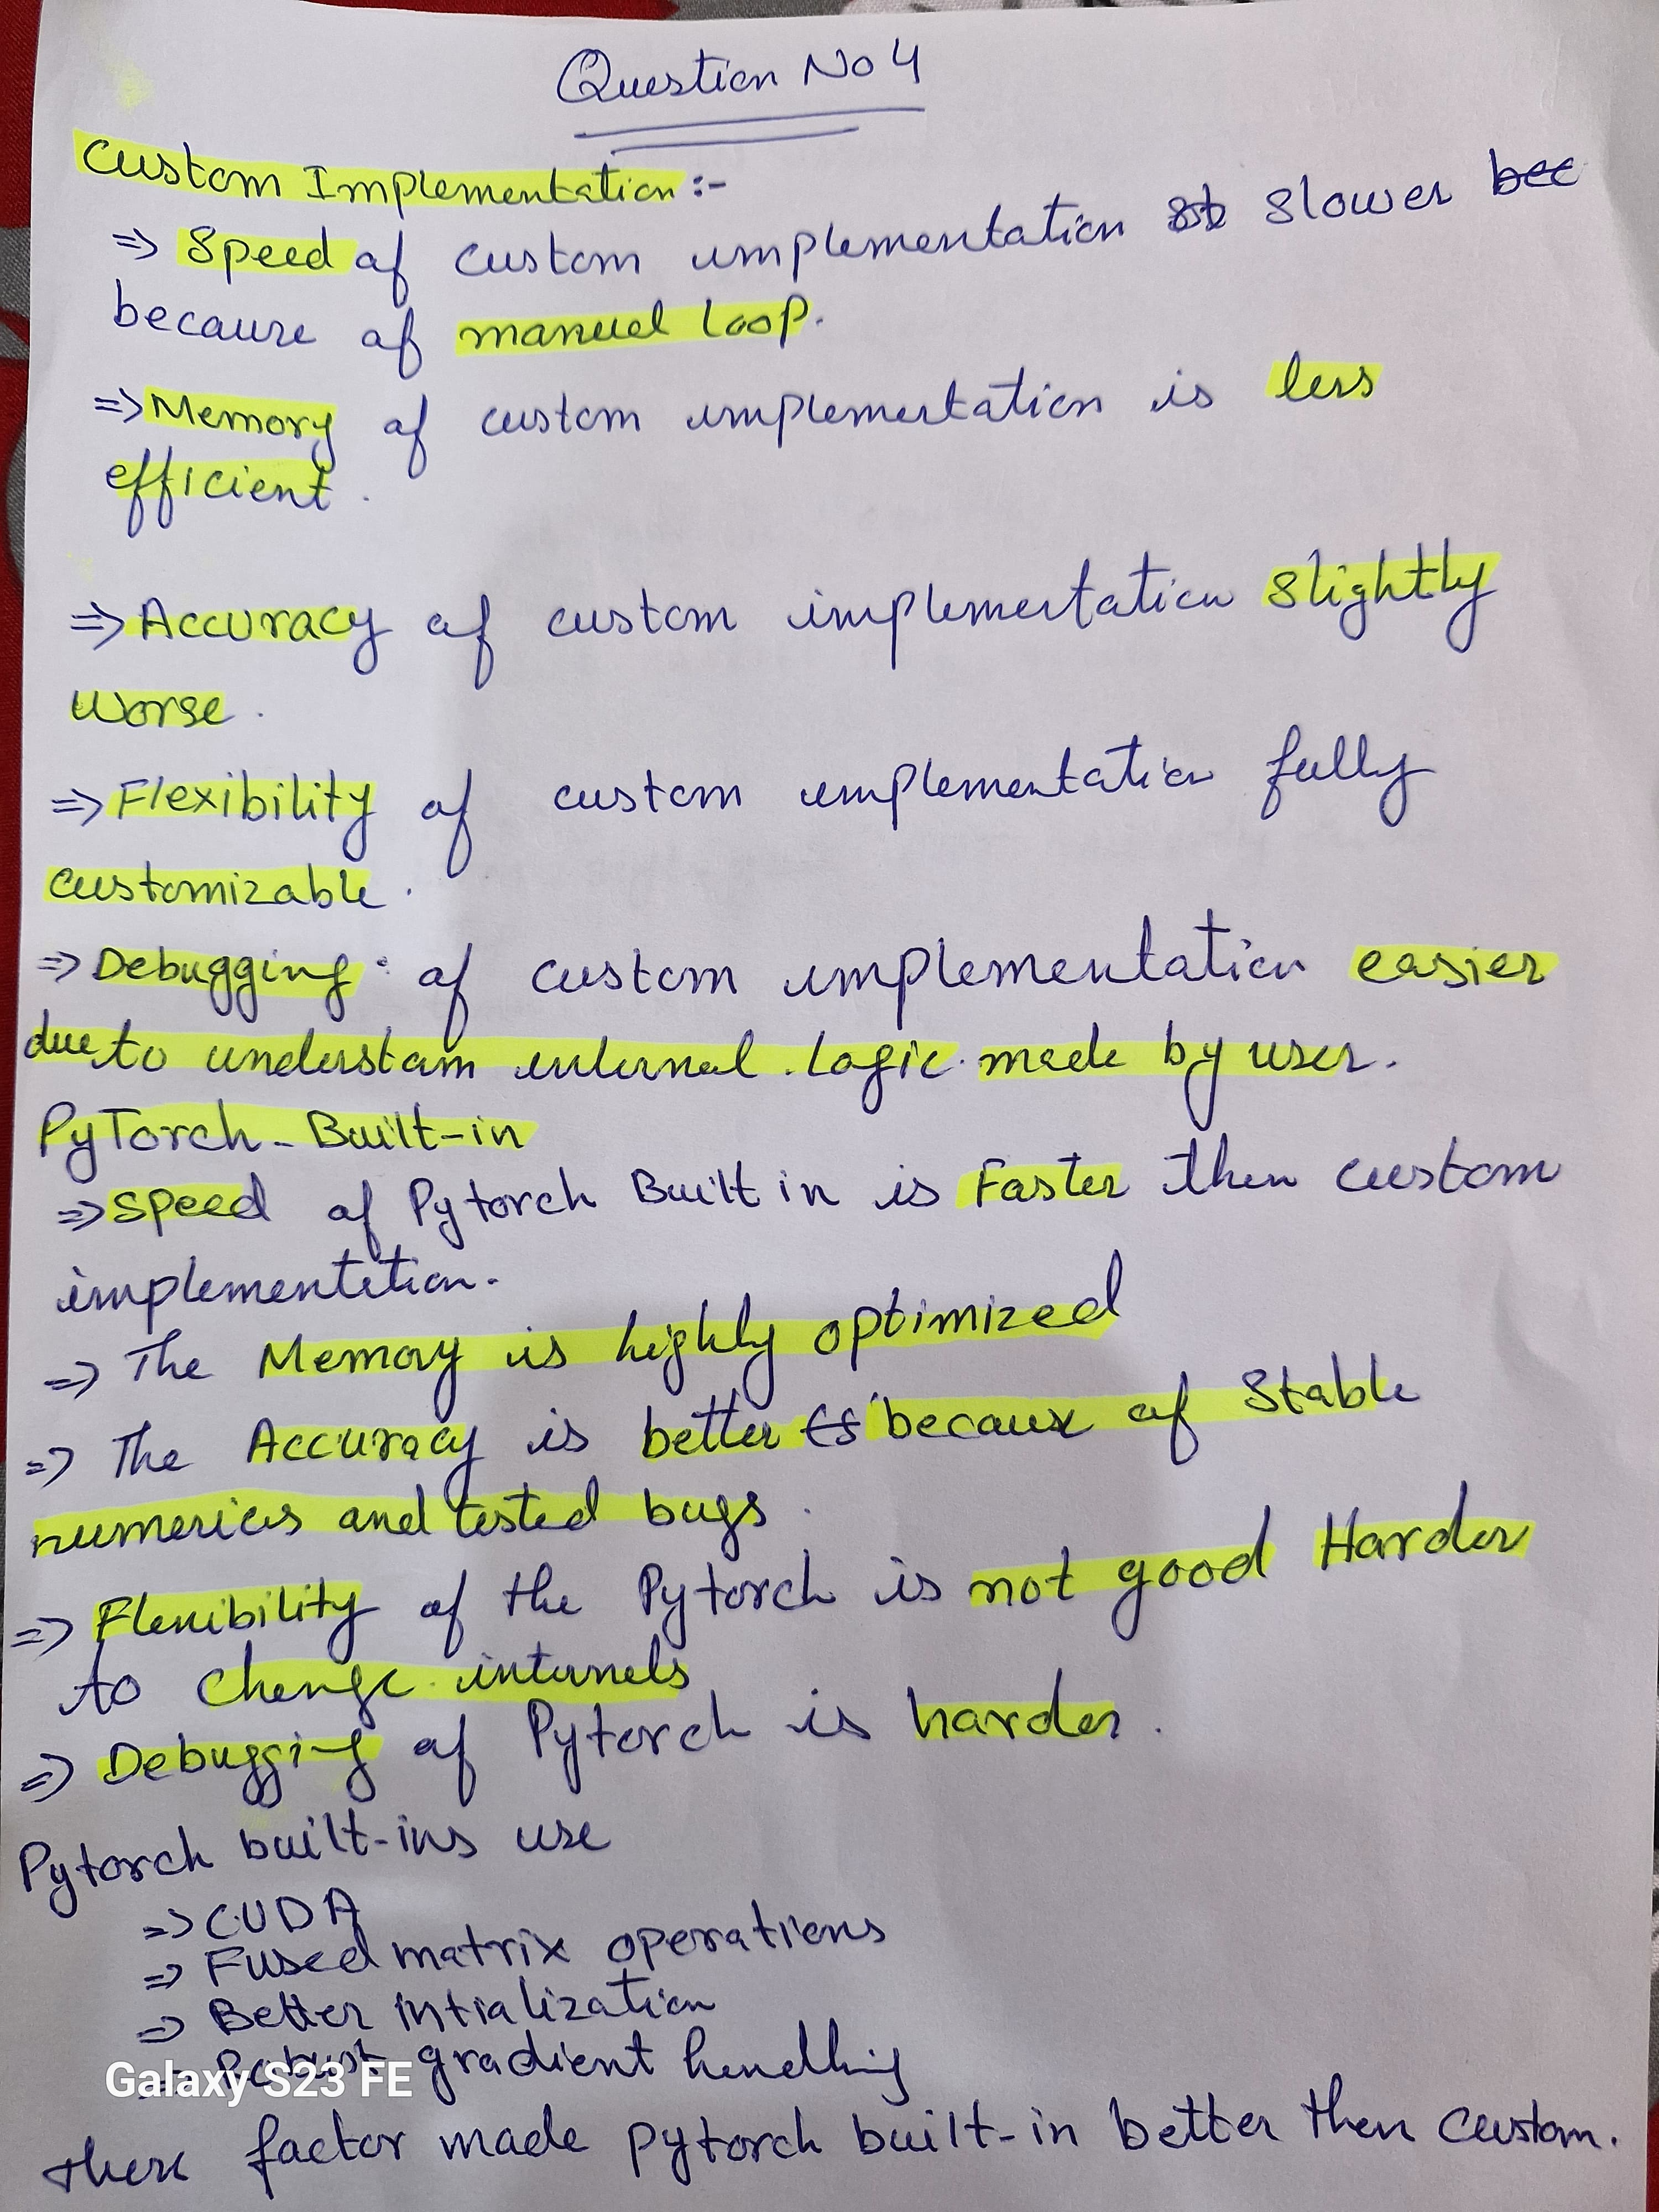

Q5: How does coupling the input and forget gates in an LSTM affect the model’s ability to independently control memory retention and update, and under what conditions might this simplification be beneficial or harmful?

*coupling the gates will reduce the number of parameters and will simplify the model even further. the midel will remember and forget in a fixed manner. this maybe useful if the data has simple dependency and may risk to overfitting . it will also be beneficial where we need faster computations. its harmful where the data is complex with complex dependencies and we need to separately remeber and forget.*

I use AI, specifically ChatGPT, to correct code and syntax, and also for help in understanding theoretical questions.